In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from param_inference import MyStochasticProcess, distance
from pyabc import ABCSMC, RV, Distribution, AggregatedTransition, DiscreteJumpTransition, MultivariateNormalTransition, GridSearchCV
from pyabc.visualization import *
from pyabc.weighted_statistics import *
from calc_observables import plot_errorshade

In [2]:
figwidth = 6.224
golden_ratio = 1.61803
figsize = (figwidth, figwidth / golden_ratio)
import matplotlib as mpl
# plt.style.use('seaborn-white')
sns.set_style("ticks")
sns.set_palette('colorblind')
mpl.rcParams['figure.figsize'] = figsize


In [3]:
n = int(3e5)
k_domain = np.arange(1, 11)
data = np.load('casespm_de_mar16_jun6.npy') * n / 1e6
data2 = np.load('casespm_de_jun7_sep15.npy') * n / 1e6
data3 = np.load('cases_de_feb26_mar16.npy')
tmax = len(data)
prior = Distribution(n01=RV('uniform', 0, int(data.max())),
                     n02=RV('uniform', 0, 10 * int(data.max())),
                     k=RV('randint', 1, 11),
                     log_p=RV('uniform', 0, 6),
                     p_inf=RV('uniform', 0.01, 0.03))
model = MyStochasticProcess(n, tmax, data)
transition = AggregatedTransition(mapping={
    # 'n01': DiscreteJumpTransition(domain=np.arange(int(data.max()))),
    # 'n02': DiscreteJumpTransition(domain=np.arange(10 * int(data.max()))),
    'k': DiscreteJumpTransition(domain=k_domain, p_stay=0.7),
    ('n01', 'n02', 'log_p', 'p_inf'): MultivariateNormalTransition(scaling=0.7)})

id = 'n=3e5_2'
db = "sqlite:///" + os.path.join(os.getcwd(), id+".db")
hid = int(np.load('run_id_'+id+'.npy'))

abc = ABCSMC(model, prior, distance, transitions=transition)
abc.load(db, hid)
history = abc.history
df, w = history.get_distribution()


id2 = 'early_growth'
db2 = "sqlite:///" + os.path.join(os.getcwd(), id2+".db")
hid2 = int(np.load('run_id_'+id2+'.npy'))

abc2 = ABCSMC(model, prior, distance, transitions=transition)
abc2.load(db2, hid2)
history2 = abc2.history
df2, w2 = history2.get_distribution()

id3 = 'n=3e5_late'
db3 = "sqlite:///" + os.path.join(os.getcwd(), id3+".db")
hid3 = int(np.load('run_id_'+id3+'.npy'))

abc3 = ABCSMC(model, prior, distance, transitions=transition)
abc3.load(db3, hid3)
history3 = abc3.history
df3, w3 = history3.get_distribution()

N1 = len(w)
N2 = len(w2)
N3 = len(w3)


In [4]:
%matplotlib inline

In [5]:
print(hid, history.max_t)
print(hid2, history2.max_t)
print(hid3, history3.max_t)
# plot_kde_matrix(df, w)

1 12
2 28
5 7


In [6]:
print(N1, effective_sample_size(w), N2, effective_sample_size(w2), N3, effective_sample_size(w3))

200 105.53155894469771 100 45.52808471248815 200 164.4510612963329


C:\Users\simon\Anaconda3\lib\site-packages\pyabc\visualization\kde.py:350: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(X, Y, PDF, **kwargs)
C:\Users\simon\Anaconda3\lib\site-packages\pyabc\visualization\kde.py:350: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(X, Y, PDF, **kwargs)
C:\Users\simon\Anaconda3\lib\site-packages\pyabc\visualization\kde.py:350: MatplotlibDeprecationWarning: shading='flat' when X and Y hav

array([[<AxesSubplot:ylabel='k'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='log_p'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='n01'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='n02'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='k', ylabel='p_inf'>,
        <AxesSubplot:xlabel='log_p'>, <AxesSubplot:xlabel='n01'>,
        <AxesSubplot:xlabel='n02'>, <AxesSubplot:xlabel='p_inf'>]],
      dtype=object)

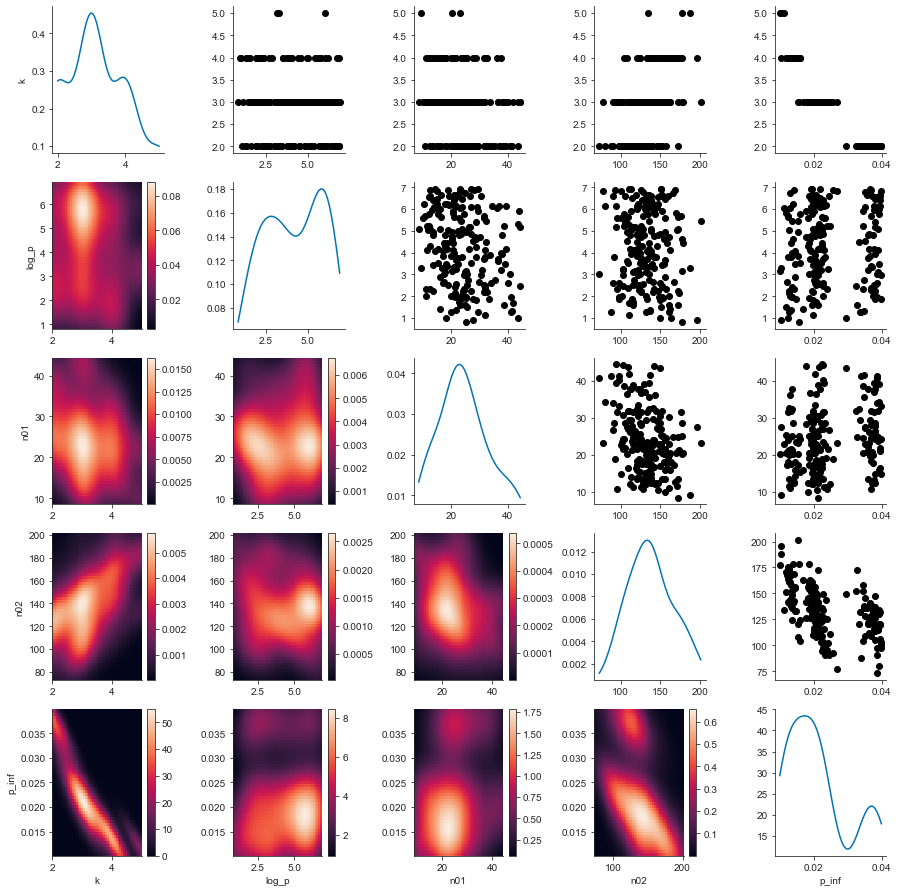

In [7]:
plot_kde_matrix(df, w)

<AxesSubplot:title={'center':'Acceptance rates'}, xlabel='Population index $t$', ylabel='Acceptance rate'>

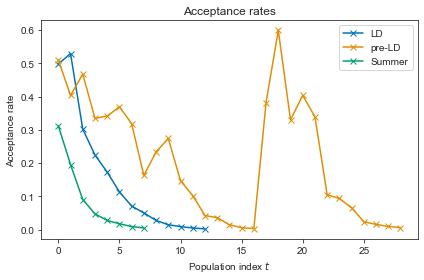

In [8]:
plot_acceptance_rates_trajectory([history, history2, history3], labels=['LD', 'pre-LD', 'Summer'])

(0.0, 7415.878402455973)

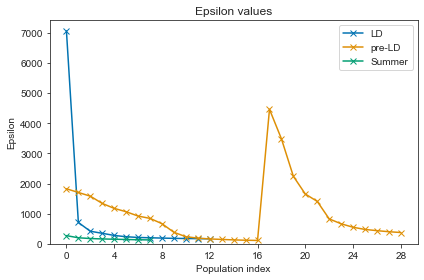

In [9]:
plot_epsilons([history, history2, history3], labels=['LD', 'pre-LD', 'Summer'])
plt.ylim(0)

<AxesSubplot:title={'center':'Effective sample size'}, xlabel='Population index', ylabel='ESS'>

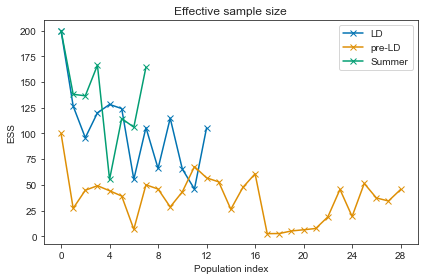

In [10]:
plot_effective_sample_sizes([history, history2, history3], labels=['LD', 'pre-LD', 'Summer'])

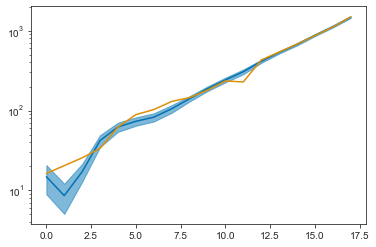

In [13]:
sum_stats = history2.get_weighted_sum_stats_for_model()  # sum_stats[0] are the weights
# sum_stats
late = []
for stored in sum_stats[1]:
    late.append(stored['cases'])
    # plt.plot(stored["cases"])

# print(len(late), len(sum_stats[0]))
plot_errorshade(range(len(data3)), np.average(late, weights=sum_stats[0], axis=0), np.std(late, axis=0))
plt.plot(data3)
plt.yscale('log')

(1, 33.582285789868614)

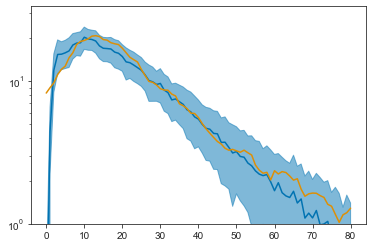

In [15]:
sum_stats = history.get_weighted_sum_stats_for_model()  # sum_stats[0] are the weights
# sum_stats
late = []
for stored in sum_stats[1]:
    late.append(stored['cases'])
    # plt.plot(stored["cases"])

# print(len(late), len(sum_stats[0]))
plot_errorshade(range(len(data)), np.average(late, weights=sum_stats[0], axis=0), np.std(late, axis=0))
plt.plot(data)
# plt.xlim(0, 10)
plt.yscale('log')
plt.ylim(1)

(0.5, 10.436681983955365)

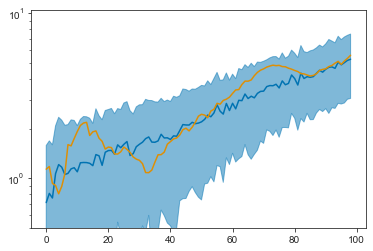

In [79]:
sum_stats = history3.get_weighted_sum_stats_for_model()  # sum_stats[0] are the weights
# sum_stats
late = []
for stored in sum_stats[1]:
    late.append(stored['cases'])
    # plt.plot(stored["cases"])

# print(len(late), len(sum_stats[0]))
plot_errorshade(range(len(data2)), np.average(late, weights=sum_stats[0], axis=0), np.std(late, axis=0))
plt.plot(data2)
plt.yscale('log')
plt.ylim(0.5)

In [16]:
df['p'] = 10**(-df['log_p'])
df2['p'] = 10**(-df2['log_p'])
df3['p'] = 10**(-df3['log_p'])
df['2k'] = df.k*2
df2['2k'] = df2.k*2
df3['2k'] = df3.k*2

In [17]:
def errorprop_p(logp, deltalogp):
    dp = np.abs(10**(-logp)*np.log(10)) * deltalogp
    return dp

In [20]:
def plot_statistics(dfs, ws):
    for param in dfs[0]:
        print('Parameter ', param, '\n', '-'*20)
        for df, w in zip(dfs, ws):
            if param in df:
                a = df[param].to_numpy()
                if param == 'p':
                    print('mean =', weighted_mean(a, w), 'std =', errorprop_p(weighted_mean(a, w), weighted_std(a, w)))
                    print('median =', weighted_median(a,w), '[', weighted_quantile(a, weights=w, alpha=.025), ',',
                    weighted_quantile(a, weights=w, alpha=.975), ']')
                else:

                    print('mean  =', weighted_mean(a, w), 'std =', weighted_std(a, w))
                    print('median =', weighted_median(a,w), '[', weighted_quantile(a, weights=w, alpha=.025), ',',
                    weighted_quantile(a, weights=w, alpha=.975), ']')
                print()

In [21]:
plot_statistics([df, df2, df3], [w, w2, w3])

Parameter  k 
 --------------------
mean  = 3.1777768728604707 std = 0.9012196724497451
median = 3.0 [ 2.0 , 5.0 ]

mean  = 13.266869833940204 std = 1.559655924535553
median = 13.0 [ 11.0 , 16.0 ]

mean  = 5.89380585607867 std = 2.0393533591589343
median = 6.0 [ 3.0 , 10.0 ]

Parameter  log_p 
 --------------------
mean  = 4.124832366000222 std = 1.8245434654376
median = 4.124289037934652 [ 0.9372748220455843 , 6.889284291428129 ]

mean  = 0.3042608259682437 std = 0.168950027800037
median = 0.3159828612510364 [ 0.028035973761766975 , 0.6471469936773415 ]

mean  = 1.481922506367138 std = 0.6847357224411448
median = 1.5246143567506356 [ 0.22313629366438154 , 2.8505238464882887 ]

Parameter  n01 
 --------------------
mean  = 24.61856562538871 std = 9.263638209372141
median = 23.42485572038428 [ 9.213466869466664 , 43.961333974896405 ]

mean  = 30.6680094052273 std = 12.500364028843915
median = 32.596630048473166 [ 4.307547533035058 , 46.366100616296244 ]

Parameter  n02 
 ---------------

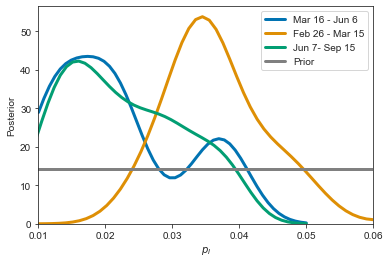

In [23]:
# bins = np.linspace(0.01, 0.03, 20, endpoint=False)
# plot_histogram_1d(history, x='p_inf', align='left', bins=bins)
plot_kde_1d(df, w, 'p_inf', xmin=0.01, xmax=0.05, label='Mar 16 - Jun 6', lw=3)
plot_kde_1d(df2, w2, 'p_inf', xmin=0.01, xmax=0.06, label='Feb 26 - Mar 15', ax=plt.gca(), lw=3)
plot_kde_1d(df3, w3, 'p_inf', xmin=0.005, xmax=0.05, label='Jun 7- Sep 15', ax=plt.gca(), lw=3)

plt.plot([0.01, 0.07], [1./0.07, 1./0.07], label='Prior', color='gray', lw=3)
plt.ylim(0)
plt.xlim(0.01, 0.06)
plt.xlabel('$p_I$')
plt.legend()

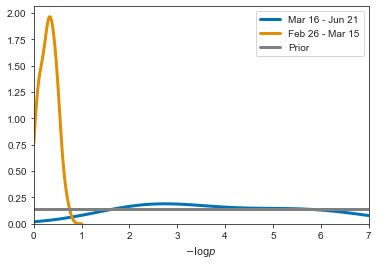

In [85]:
# bins = np.linspace(0, 6, 20, endpoint=False)
# plot_histogram_1d(history, x='log_p', bins=bins, align='left')

plot_kde_1d(df, w, 'log_p', xmin=0, xmax=7, label='Mar 16 - Jun 21', lw=3)
plot_kde_1d(df2, w2, 'log_p', xmin=0, xmax=1, label='Feb 26 - Mar 15', ax=plt.gca(), lw=3)
plt.plot([0, 7], [1./7, 1./7], 'gray', label='Prior', lw=3)
plt.ylim(0)
plt.xlim(0, 7)
plt.ylabel('')
plt.xlabel('$-\\log p$')
plt.legend()

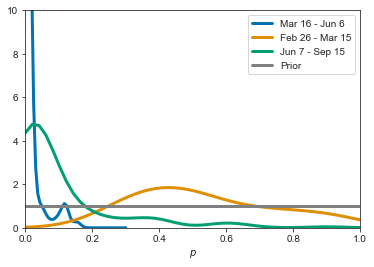

In [25]:
plot_kde_1d(df, w, 'p', xmin=0, xmax=.3, label='Mar 16 - Jun 6', lw=3)
plot_kde_1d(df2, w2, 'p', xmin=0, xmax=1, label='Feb 26 - Mar 15', ax=plt.gca(), lw=3)
plot_kde_1d(df3, w3, 'p', xmin=0, xmax=1, label='Jun 7 - Sep 15', ax=plt.gca(), lw=3)
plt.plot([0, 1], [1., 1.], 'gray', label='Prior', lw=3)
plt.ylim(0, 10)
plt.xlim(0, 1)
plt.ylabel('')
plt.xlabel('$p$')
plt.legend()

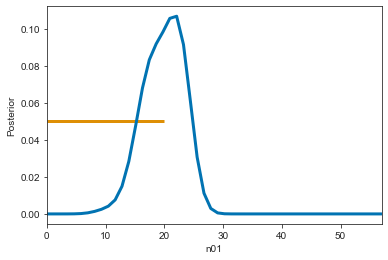

In [87]:
# plot_histogram_1d(history, x='n01', bins=np.arange(20), align='left')
plot_kde_1d(df, w, 'n01', xmin=0, xmax=57, lw=3)
plt.hlines(1/20, 0, 20, colors='C1', lw=3)

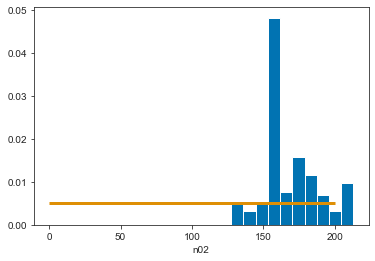

In [88]:
plot_histogram_1d(history, x='n02', bins=10, align='left')
plt.hlines(1/200, 0, 200, colors='C1', lw=3)

(2.0, 32.0)

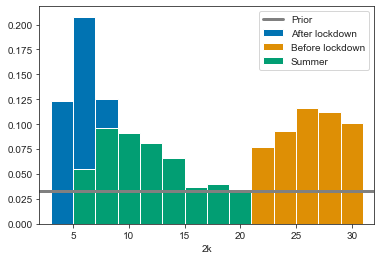

In [26]:
bins = np.arange(2, 34, 2)
plot_histogram_1d_lowlevel(df, w, x='2k', bins=bins, align='left', label='After lockdown')
plot_histogram_1d_lowlevel(df2, w2, x='2k', bins=bins, align='left', label='Before lockdown', ax=plt.gca())
plot_histogram_1d_lowlevel(df3, w3, x='2k', bins=bins, align='left', label='Summer', ax=plt.gca())
plt.plot([2, 32], [1./30, 1./30], color='gray', lw=3, label='Prior')
plt.legend()
plt.xlim(2, 32)

Text(0.5, 0, '$k$')

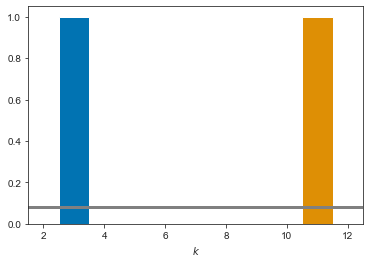

In [90]:
bins = np.arange(13)
plot_histogram_1d(history, x='k', bins=bins, align='left', label='After lockdown')
plot_histogram_1d(history2, x='k', bins=bins, align='left', label='Before lockdown', ax=plt.gca())
plt.plot([0.5, 12.5], [1./12, 1./12], color='gray', lw=3, label='Prior')
# plt.legend()
plt.xlim(1.5, 12.5)
plt.xlabel('$k$')

C:\Users\simon\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


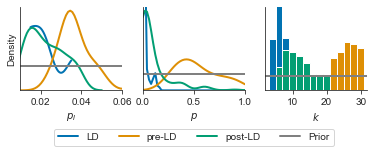

In [27]:
wi = figwidth
lw = 2
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=False, sharex=False, figsize=(wi, 0.4*wi/golden_ratio),
                        gridspec_kw={'hspace': 0.1, 'wspace': 0.2}, tight_layout=True)
plt.sca(axs[0])
plot_kde_1d(df, w, 'p_inf', xmin=0.015, xmax=0.035, label='LD', ax=axs[0], lw=lw)
plot_kde_1d(df2, w2, 'p_inf', xmin=0.01, xmax=0.06, label='pre-LD', ax=axs[0], lw=lw)
plot_kde_1d(df3, w3, 'p_inf', xmin=0.005, xmax=0.05, label='post-LD', ax=axs[0], lw=lw)

plt.plot([0.01, 0.06], [1./0.06, 1./0.06], label='Prior', color='gray', lw=lw)
plt.ylim(0)
plt.xlim(0.01, 0.06)
plt.xlabel('$p_I$')
plt.xlabel('$p_I$')
plt.ylabel('Density')
# axs[1].legend(# handles = [l1,l2,l3] , labels=['A', 'B', 'C'],)
plt.yticks([])

plt.sca(axs[1])
plot_kde_1d(df, w, 'p', xmin=0, xmax=1, label='LD', ax=axs[1], lw=lw)
plot_kde_1d(df2, w2, 'p', xmin=0, xmax=1, label='pre-LD', ax=axs[1], lw=lw)
plot_kde_1d(df3, w3, 'p', xmin=0, xmax=1, label='post-LD', ax=axs[1], lw=lw)
plt.plot([0, 1], [1., 1.], 'gray', label='Prior', lw=lw)
plt.ylim(0, 5)
plt.xlim(0, 1)
plt.ylabel('')
plt.xlabel('$p$')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=4)

plt.yticks([])

plt.sca(axs[2])
bins = np.arange(2, 34, 2)
plot_histogram_1d_lowlevel(df, w, x='2k', bins=bins, align='left', ax=axs[2])
plot_histogram_1d_lowlevel(df2, w2, x='2k', bins=bins, align='left', ax=axs[2])
plot_histogram_1d_lowlevel(df3, w3, x='2k', bins=bins, align='left', ax=axs[2])

# plot_histogram_1d_lowlevel(df3, w3, x='2k', bins=bins, align='left', label='Summer', ax=plt.gca())
plt.plot([2, 32], [1./30, 1./30], color='gray', lw=lw, label='Prior')
plt.xlim(2, 32)
plt.ylim(0, 0.2)
# plt.legend()
plt.xlabel('$k$')
plt.yticks([])
sns.despine()
# plt.savefig('./figures/abc.svg', bbox_inches='tight', pad_inches=0)

In [62]:
data[:4].sum(), data[0]

(38.19412390048019, 8.273355823399356)

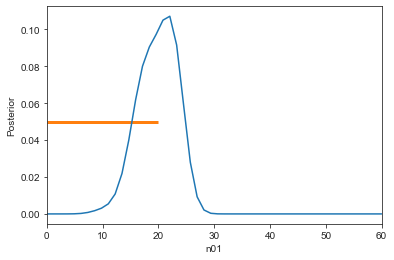

In [37]:
# plot_histogram_1d(history, x='n01', bins=np.arange(20), align='left')
plot_kde_1d(df, w, 'n01', xmin=0, xmax=3*int(data.max()))
plt.hlines(1/20, 0, 20, colors='C1', lw=3)

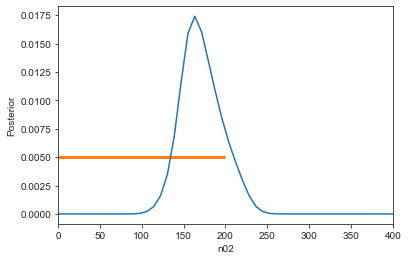

In [63]:
plot_kde_1d(df, w, 'n02', xmin=0, xmax=50*int(data[0]))
plt.hlines(1/200, 0, 200, colors='C1', lw=3)